c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\deeptrack\__init__.py:14: UserWarning: TensorFlow is detected in your environment. DeepTrack2 version 2.0++ no longer supports TensorFlow. If you need TensorFlow support, please install the legacy version 1.7 of DeepTrack2:

    pip install deeptrack==1.7

For more details, refer to the DeepTrack documentation.
  warnings.warn(


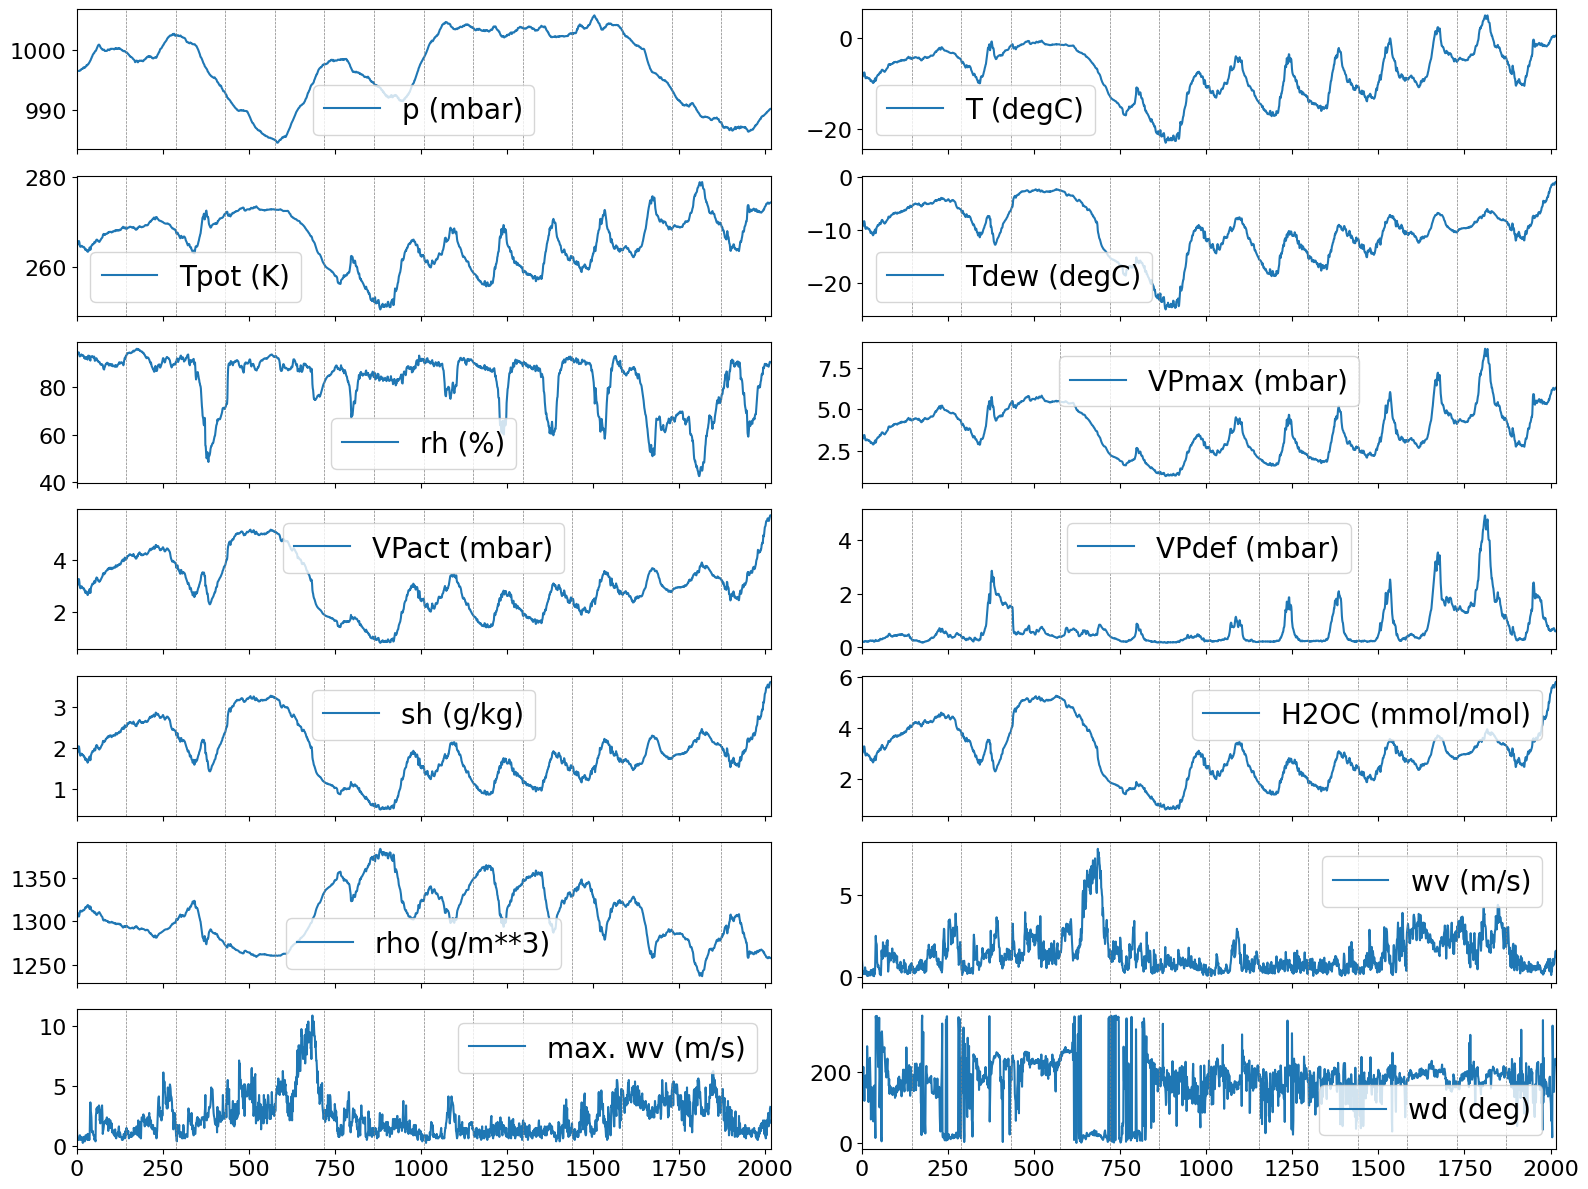

In [ ]:
#%% Import libraries and data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import deeptrack as dt
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import deeplay as dl
from matplotlib.ticker import FixedLocator
from torch_geometric.nn.norm import LayerNorm

dataframe = pd.read_csv("jena_climate_2009_2016.csv", index_col=0)
data = dataframe.values
header = dataframe.columns.tolist()

start, days, daily_samples = 0, 14, 144
end = start + daily_samples * days

fig, axs = plt.subplots(7, 2, figsize=(16, 12), sharex=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(np.arange(start, end), data[start:end, i], label=header[i])
    ax.set_xlim(start, end)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=20)

    for day in range(1, days):
        ax.axvline(x=start + daily_samples * day,
                   color="gray", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# %%

n_samples, n_features = data.shape[0], data.shape[1]
past_seq = 2 * daily_samples
lag = 72
temp_idx = 1  # Temperature (Celsius) index.

in_sequences, targets = [], []
for i in range(past_seq, n_samples - lag, daily_samples):
    in_sequences.append(data[i - past_seq:i, :])
    targets.append(data[i + lag:i + lag + 1, temp_idx])
in_sequences, targets = np.asarray(in_sequences), np.asarray(targets)

sources = dt.sources.Source(inputs=in_sequences, targets=targets)
train_sources, val_sources = dt.sources.random_split(sources, [0.8, 0.2])

train_mean = np.mean([src["inputs"] for src in train_sources], axis=(0, 1))
train_std = np.std([src["inputs"] for src in train_sources], axis=(0, 1))

inputs_pipeline = (dt.Value(sources.inputs - train_mean) / train_std
                   >> dt.pytorch.ToTensor(dtype=torch.float))
targets_pipeline = (dt.Value(sources.targets - train_mean[temp_idx]) 
                    / train_std[temp_idx])

train_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                   inputs=train_sources)
val_dataset = dt.pytorch.Dataset(inputs_pipeline & targets_pipeline,
                                 inputs=val_sources)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

temperature = data[:, temp_idx]
benchmark_celsius = np.mean(
    np.abs(
        temperature[daily_samples + lag::daily_samples]
        - temperature[lag:-(daily_samples - lag):daily_samples]
    )
)
benchmark = benchmark_celsius / train_std[temp_idx]

def plot_training(epochs, train_losses, val_losses, benchmark):
    """Plot the training and validation losses."""
    plt.plot(range(epochs), train_losses, label="Training Loss")
    plt.plot(range(epochs), val_losses, "--", label="Validation Loss")
    plt.plot([0, epochs - 1], [benchmark, benchmark], ":k", label="Benchmark")
    plt.xlabel("Epoch")
    plt.xlim([0, epochs - 1])
    plt.ylabel("Loss")
    plt.ylim(top = 0.7)
    plt.legend()
    plt.show()

class DotProductAttention(dl.DeeplayModule):
    """Dot-product attention."""

    def __init__(self):
        """Initialize dot-product attention."""
        super().__init__()

    def forward(self, queries, keys, values):
        """Calculate dot-product attention."""
        attn_scores = (torch.matmul(queries, keys.transpose(-2, -1))
                       / (keys.size(-1) ** 0.5))
        attn_matrix = torch.nn.functional.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_matrix, values)
        return attn_output, attn_matrix
    
def plot_attention(query_tokens, key_tokens, attn_matrix, title="Attention matrix", tick_interval=12):
    fig, ax = plt.subplots(figsize=(10, 2))
    cax = ax.matshow(attn_matrix, cmap="Greens", aspect="auto")
    fig.colorbar(cax)
    ax.set_title(title, fontsize=14, pad=12)

    # Use fewer ticks to avoid clutter
    xticks = list(range(0, len(key_tokens), tick_interval))
    ax.set_xticks(xticks)
    ax.set_xticklabels([key_tokens[i] for i in xticks], rotation=90)

    ax.set_yticks(range(len(query_tokens)))
    ax.set_yticklabels(query_tokens)
    plt.tight_layout()
    plt.show()

class GRUWithCrossAttention(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.0):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, dropout=dropout)
        self.query_proj = nn.Linear(hidden_dim, input_dim)
        self.attn = DotProductAttention()
        self.fc = nn.Linear(hidden_dim + input_dim, output_dim)

    def forward(self, x, return_attention=False):
        # x: (batch, seq_len, input_dim)
        gru_out, h_n = self.gru(x)
        query = h_n[-1].unsqueeze(1)  # (batch, 1, hidden_dim)
        query_mapped = self.query_proj(query)  # (batch, 1, input_dim)

        # Apply dot-product attention: query vs input sequence
        attn_output, attn_matrix = self.attn(query_mapped, x, x)  # shapes: (batch, 1, input_dim), (batch, 1, seq_len)

        combined = torch.cat([query.squeeze(1), attn_output.squeeze(1)], dim=-1)
        output = self.fc(combined)

        if return_attention:
            return output, attn_matrix
        return output

INFO: 
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricCollection | 0      | train
4 | model         | RecurrentModel   | 1.4 K  | train
5 | optimizer     | Adam             | 0      | train
-----------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | L1Loss           | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollec

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

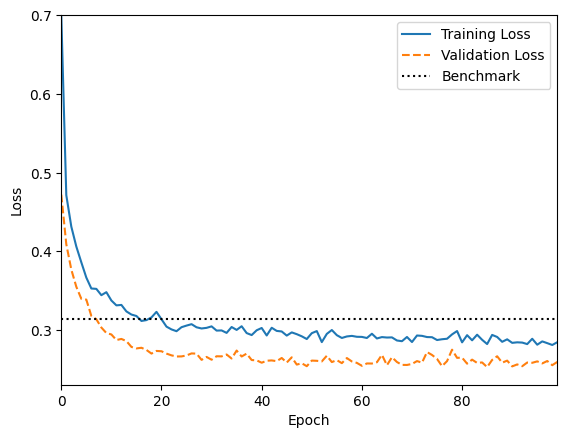

In [ ]:
#%% Old GRU

epochs = 100

gru_dl = dl.RecurrentModel(
    in_features=n_features,
    hidden_features=[8, 8, 8],
    out_features=1,
    rnn_type="GRU",
    dropout=0.2,
)
gru_stacked = dl.Regressor(gru_dl, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(gru_stacked, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

INFO: 
  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | loss          | L1Loss                | 0      | train
1 | train_metrics | MetricCollection      | 0      | train
2 | val_metrics   | MetricCollection      | 0      | train
3 | test_metrics  | MetricCollection      | 0      | train
4 | model         | GRUWithCrossAttention | 1.6 K  | train
5 | optimizer     | Adam                  | 0      | train
----------------------------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name          | Type                  | Params | Mode 
----------------------------------------------------------------
0 | loss          | L1Loss                | 0      | train
1 | train_metrics | Metric

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Green\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

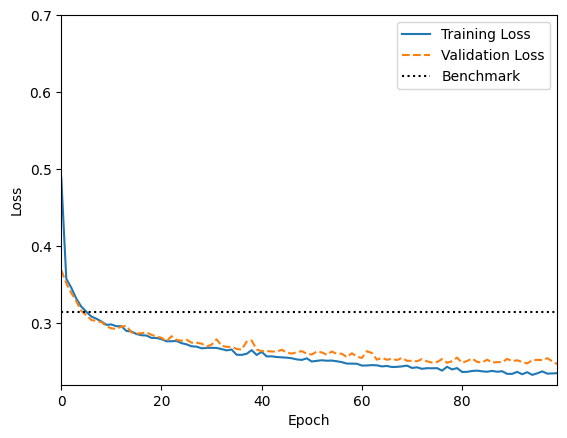

In [ ]:
#%% Attention GRU

epochs = 100

attn_model = GRUWithCrossAttention(input_dim=n_features, 
                                   hidden_dim=8, 
                                   output_dim=1, 
                                   num_layers=3, 
                                   dropout=0.2)
attn_regressor = dl.Regressor(attn_model, optimizer=dl.Adam(lr=0.001)).create()

trainer = dl.Trainer(max_epochs=epochs, accelerator="auto")
trainer.fit(attn_regressor, train_loader, val_loader)

train_losses = trainer.history.history["train_loss_epoch"]["value"]
val_losses = trainer.history.history["val_loss_epoch"]["value"][1:]
plot_training(epochs, train_losses, val_losses, benchmark)

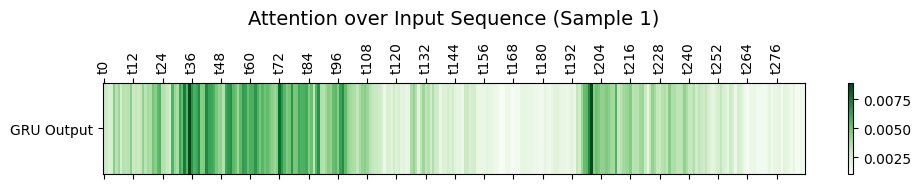

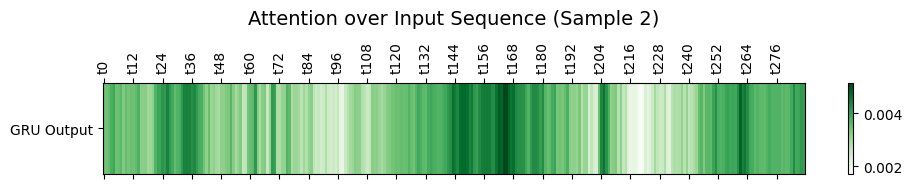

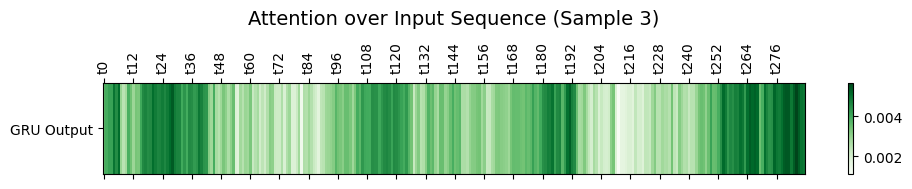

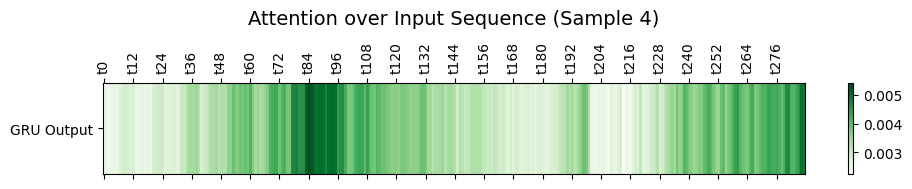

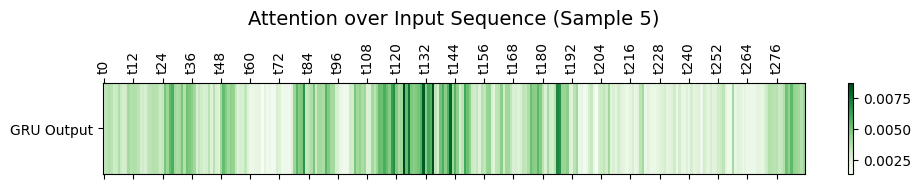

In [ ]:
# %% Attention matrix with 12 tick interval

model = attn_regressor.model
model.eval()

# How many sequences to visualize
num_sequences_to_plot = 5

# Load one batch from the validation set
batch = next(iter(val_loader))
inputs, _ = batch  # Shape: (batch_size, seq_len, n_features)

for i in range(min(num_sequences_to_plot, inputs.shape[0])):
    x_seq = inputs[i].unsqueeze(0)  # Shape: (1, seq_len, n_features)

    with torch.no_grad():
        _, attn_matrix = model(x_seq, return_attention=True)

    # Extract attention matrix for sample i
    attn = attn_matrix[0, 0].cpu().numpy()  # Shape: (seq_len,)
    
    # Token labels for timesteps
    seq_len = attn.shape[0]
    tokens = [f"t{j}" for j in range(seq_len)]

    # Plot
    plot_attention(["GRU Output"], tokens, attn[np.newaxis, :],
                   title=f"Attention over Input Sequence (Sample {i + 1})", tick_interval=12)

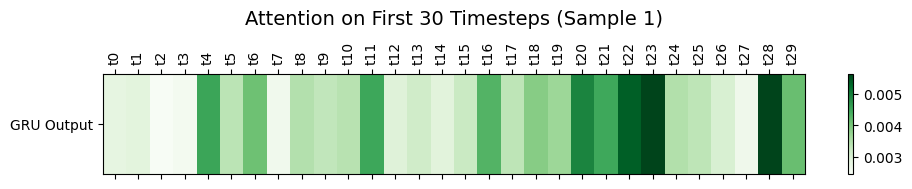

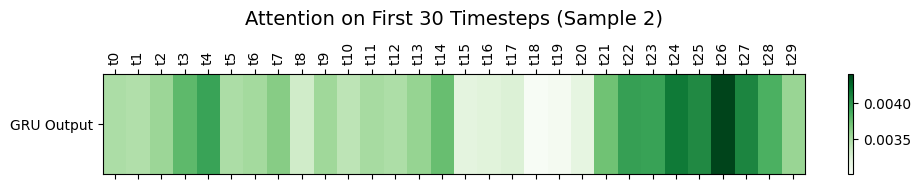

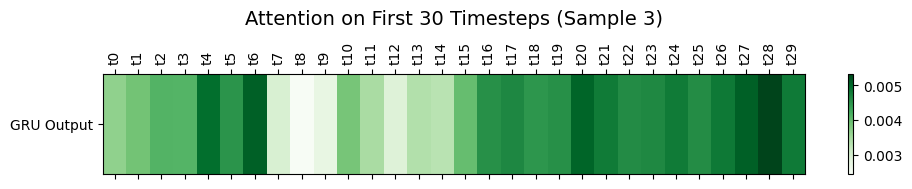

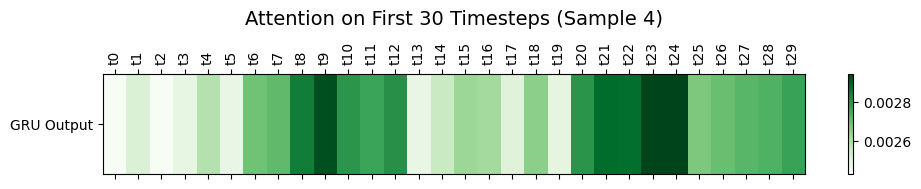

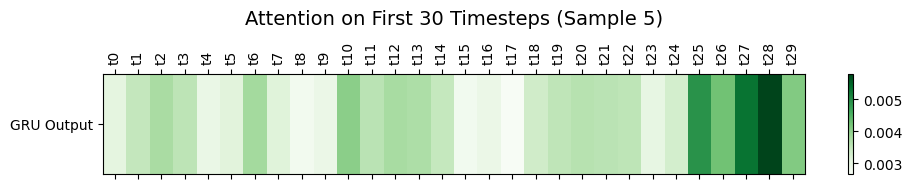

In [ ]:
# %%

model = attn_regressor.model
model.eval()

num_sequences_to_plot = 5
crop_len = 30

batch = next(iter(val_loader))
inputs, _ = batch  # Shape: (batch_size, seq_len, n_features)

for i in range(min(num_sequences_to_plot, inputs.shape[0])):
    x_seq = inputs[i].unsqueeze(0)  # Shape: (1, seq_len, n_features)

    with torch.no_grad():
        _, attn_matrix = model(x_seq, return_attention=True)

    # Extract and crop attention
    attn = attn_matrix[0, 0, :crop_len].cpu().numpy()  # Shape: (crop_len,)
    tokens = [f"t{j}" for j in range(crop_len)]

    plot_attention(
        ["GRU Output"],
        tokens,
        attn[np.newaxis, :],  # Reshape to (1, crop_len) for plotting
        title=f"Attention on First {crop_len} Timesteps (Sample {i + 1})",
        tick_interval=1  # Fewer ticks for better readability
    )